# Model Training File



In [22]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [23]:
# Paths
DATASET_PATH = "datasets/processed/"
LABELS_CSV = "datasets/processed_labels.csv"
MODEL_SAVE_PATH = "tinyml_dog_model_2.h5"

In [11]:
from sklearn.utils import resample
import pandas as pd

# Load the dataset labels
df = pd.read_csv("datasets/processed_labels.csv")

# Separate majority (Dog) and minority (Not-Dog) classes
df_dog = df[df['label'] == 1]
df_not_dog = df[df['label'] == 0]

# Downsample Dog class to match Not-Dog class size
df_dog_downsampled = resample(df_dog, replace=False, n_samples=len(df_not_dog), random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_dog_downsampled, df_not_dog])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Save new dataset
df_balanced.to_csv("datasets/processed_balanced_labels.csv", index=False)

print("✅ Dataset is now balanced! New class distribution:")
print(df_balanced["label"].value_counts())


✅ Dataset is now balanced! New class distribution:
label
1    14256
0    14256
Name: count, dtype: int64


In [ ]:
# Load the new balanced dataset
df = pd.read_csv("datasets/processed_balanced_labels.csv")
df["filename"] = df["filename"].apply(lambda x: os.path.join(DATASET_PATH, x))
# Perform train-validation split
from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(
    df["filename"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# Confirm split
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Load images directly since they are already preprocessed
train_images = np.array([cv2.imread(f) for f in train_files])
val_images = np.array([cv2.imread(f) for f in val_files])
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

Training samples: 22809
Validation samples: 5703


In [48]:

# Load dataset labels
df = pd.read_csv(LABELS_CSV)
df["filename"] = df["filename"].apply(lambda x: os.path.join(DATASET_PATH, x))
print(df['label'].value_counts())  

# Perform train-validation split
train_files, val_files, train_labels, val_labels = train_test_split(
    df["filename"], df["label"], test_size=0.2, random_state=42
)

# Check dataset split
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")


# Load images directly since they are already preprocessed
train_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in train_files])
val_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in val_files])
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Expand dimensions to match model input shape (96, 96, 1)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

# Ensure pixel values are in float32 and normalized to [0,1]
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0


label
1    29976
0    14256
Name: count, dtype: int64
Training samples: 35385
Validation samples: 8847


In [49]:
# Check the number of samples in train & validation sets
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Check class balance in both sets
train_df = pd.DataFrame({"filename": train_files, "label": train_labels})
val_df = pd.DataFrame({"filename": val_files, "label": val_labels})

print("\nTraining Set Distribution:")
print(train_df["label"].value_counts())

print("\nValidation Set Distribution:")
print(val_df["label"].value_counts())

Training samples: 35385
Validation samples: 8847

Training Set Distribution:
label
1    23947
0    11438
Name: count, dtype: int64

Validation Set Distribution:
label
1    6029
0    2818
Name: count, dtype: int64


In [50]:
print(f"Training data shape: {train_images.shape}")  # Should be (batch_size, 96, 96, 1)
print(f"Validation data shape: {val_images.shape}")  # Shou

Training data shape: (35385, 96, 96, 1)
Validation data shape: (8847, 96, 96, 1)


In [65]:
model = Sequential([
    DepthwiseConv2D(kernel_size=3, depth_multiplier=1, activation="relu", input_shape=(96, 96, 1)),
    Conv2D(8, kernel_size=1, activation="relu"),
    MaxPooling2D(pool_size=2),

    DepthwiseConv2D(kernel_size=3, depth_multiplier=1, activation="relu"),
    Conv2D(16, kernel_size=1, activation="relu"),
    MaxPooling2D(pool_size=2),

    DepthwiseConv2D(kernel_size=3, depth_multiplier=1, activation="relu"),
    Conv2D(32, kernel_size=1, activation="relu"),
    MaxPooling2D(pool_size=2),

    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.4),  # Increased dropout
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print summary to check architecture
model.summary()

/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_depthwise_conv.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d_6              │ (None, 94, 94, 1)      │            10 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 94, 94, 8)      │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 47, 47, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_7              │ (None, 45, 45, 8)      │            80 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 45, 45, 16)     │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 22, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_8              │ (None, 20, 20, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 20, 20, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,419 (403.98 KB)

 Trainable params: 103,419 (403.98 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:

# Define TinyML CNN model
model = Sequential([
    Conv2D(16, (3,3), activation="relu", input_shape=(96, 96, 3)),
    MaxPooling2D((2,2)),

    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),  # Increased depth
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),  # Increased neurons
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [44]:
# Print model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843,041 (3.22 MB)

 Trainable params: 843,041 (3.22 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Image size and batch size
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 30  # Will stop early if needed


# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Compute class weights based on dataset size
class_counts = np.array([11438 + 2818, 23947 + 6029])  # Total count for each class
classes = np.array([0, 1])  # Labels: Not-Dog (0), Dog (1)

class_weights = compute_class_weight("balanced", classes=classes, y=np.repeat(classes, class_counts))
class_weights = {i: w for i, w in enumerate(class_weights)}

# Print computed class weights
print(f"Computed Class Weights: {class_weights}")


# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #class_weight=class_weights,  # Apply class balancing
    callbacks=[early_stopping]
)

# Save model
model.save(MODEL_SAVE_PATH)
print(f"✅ Model training complete! Saved as {MODEL_SAVE_PATH}")

Computed Class Weights: {0: 1.5513468013468013, 1: 0.7377902321857486}
Epoch 1/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.6758 - loss: 0.6146 - val_accuracy: 0.6913 - val_loss: 0.5786
Epoch 2/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7210 - loss: 0.5572 - val_accuracy: 0.7348 - val_loss: 0.5359
Epoch 3/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7355 - loss: 0.5350 - val_accuracy: 0.7488 - val_loss: 0.5233
Epoch 4/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7497 - loss: 0.5132 - val_accuracy: 0.7582 - val_loss: 0.5010
Epoch 5/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7619 - loss: 0.4901 - val_accuracy: 0.7720 - val_loss: 0.4770
Epoch 6/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7670 - loss: 0.4796 - val_accuracy: 0.7861 - val_loss: 0.4659
Epoch 7/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7839 - loss: 0.4525 - val_accuracy: 0.7788 - val_loss: 0.4706
Epoch

✅ Model training complete! Saved as tinyml_dog_model_2.h5


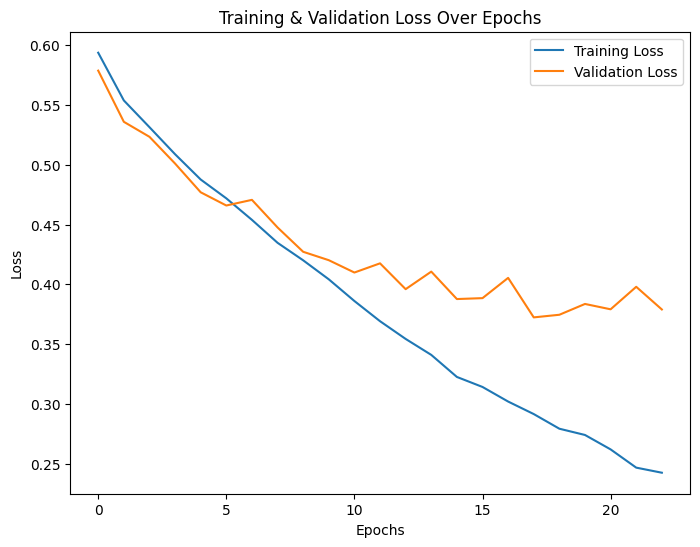

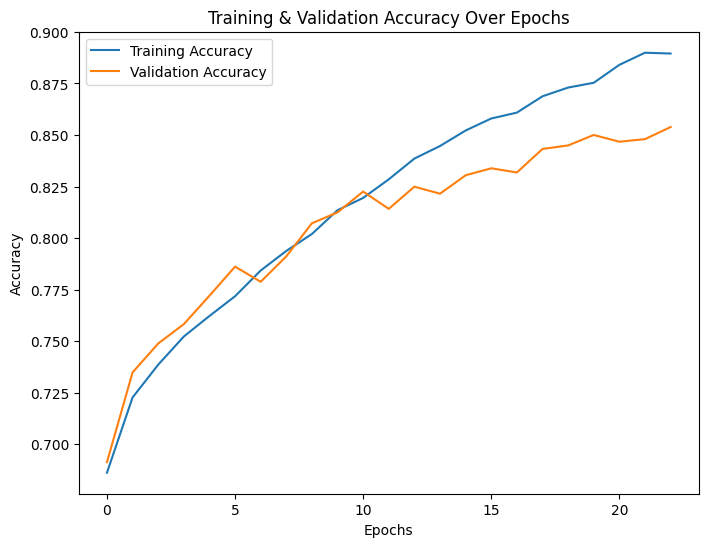

In [67]:



# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Abyssinian_71.jpg: Dog (Confidence: 0.5726000070571899)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Bengal_194.jpg: Not Dog (Confidence: 0.0003000000142492354)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Birman_1.jpg: Not Dog (Confidence: 0.30730000138282776)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
basset_hound_107.jpg: Dog (Confidence: 0.8593000173568726)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog10.jpg: Not Dog (Confidence: 0.0340999998152256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog3.png: Not Dog (Confidence: 0.27160000801086426)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog4.png: Dog (Confidence: 0.932699978351593)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
dog7.png: Not Dog (Confidence: 0.4666999876499176)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
food2.png: Not Dog (Confidence: 0.4007999897003174)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
food4.png: Dog (Confidence: 0.9965000152587891)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
food6.png: Not Dog (Confidence: 0.0318999998271465

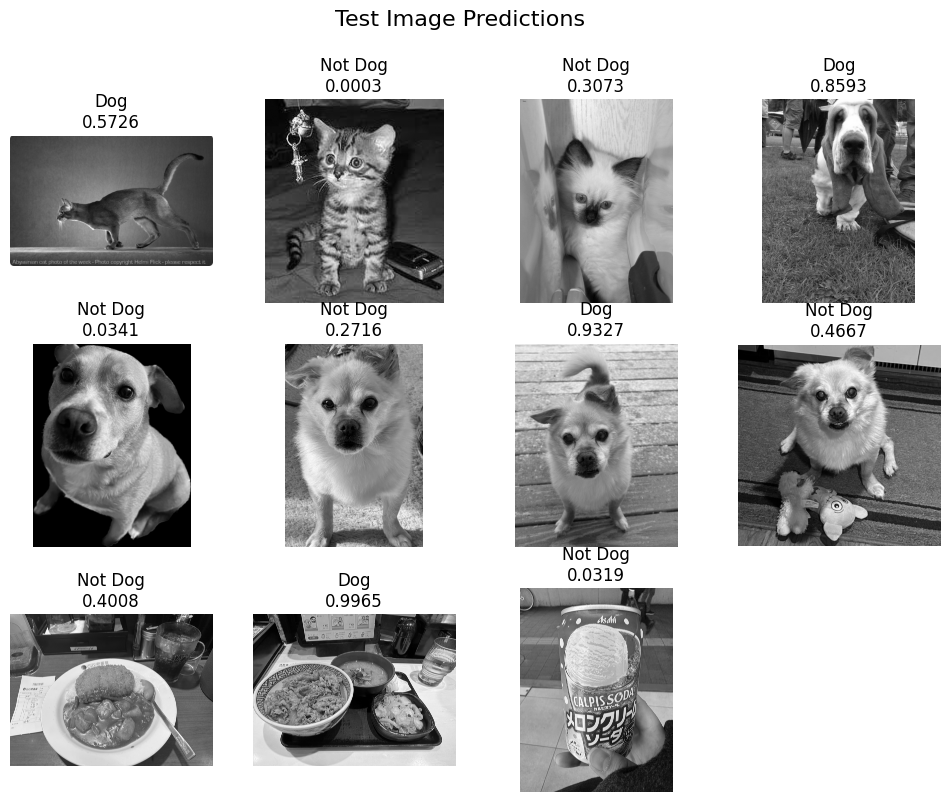

In [74]:


# Paths
MODEL_PATH = "tinyml_dog_model_2.h5"  # Path to trained model
IMAGE_PATH = "datasets/test_img/food2.png"  # Path to test image (replace with your image)
TEST_IMG_FOLDER = "datasets/test_img/"
# Load trained model
#model = tf.keras.models.load_model(MODEL_PATH)
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# Image preprocessing (same as training)
IMG_SIZE = (96, 96)  # Ensure same size used in training


def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if img is None:
        print(f"⚠️ Warning: Could not read {image_path}. Skipping...")
        return None

    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize

    img = np.expand_dims(img, axis=-1)  # Add grayscale channel dimension (96,96,1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1,96,96,1)
    return img

# Function to run predictions on all images in the test folder
def run_predictions():
    test_images = sorted(os.listdir(TEST_IMG_FOLDER))  # Sort files for consistent display
    predictions = []
    images_to_show = []

    for file in test_images:
        if file.endswith((".jpg", ".png")):
            image_path = os.path.join(TEST_IMG_FOLDER, file)
            img = preprocess_image(image_path)
            
            if img is not None:
                prediction = model.predict(img)[0][0]  # Get prediction score
                label = "Dog" if prediction > 0.5 else "Not Dog"
                confidence = round(prediction, 4)

                print(f"{file}: {label} (Confidence: {confidence})")

                # Append image and prediction for visualization
                images_to_show.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))  # Read in grayscale
                predictions.append(f"{label}\n{confidence:.4f}")

    # Display images in a matrix
    display_results(images_to_show, predictions)

# Function to display test images and predictions in a grid
def display_results(images, predictions, cols=4):
    rows = (len(images) + cols - 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.suptitle("Test Image Predictions", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap="gray")  # Display image in grayscale
            ax.set_title(predictions[i])  # Show prediction
            ax.axis("off")
        else:
            ax.axis("off")  # Hide extra subplots

    plt.show()

# Run the predictions
run_predictions()

In [14]:
import tensorflow as tf
import numpy as np

# Load your trained model
model = tf.keras.models.load_model("tinyml_dog_model_2.h5")

# Define a function to generate sample inputs
def representative_dataset():
    for _ in range(100):  # Use at least 100 samples
        dummy_input = np.random.rand(1, 96, 96, 1).astype(np.float32)  # Change to match your model's input shape
        yield [dummy_input]

# Convert the model with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Force int8 quantization
converter.inference_input_type = tf.int8  # Ensure input is int8
converter.inference_output_type = tf.int8  # Ensure output is int8

# Convert and save the quantized model
quantized_model = converter.convert()
with open("dog_detect_quantized.tflite", "wb") as f:
    f.write(quantized_model)

print("✅ Model successfully quantized!")


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpy8_iv9ud/assets


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpy8_iv9ud/assets


Saved artifact at '/var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpy8_iv9ud'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer_8')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  14361547152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361548496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361547920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361549456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361549264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361550224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361550032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361550992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361550800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361551760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14361551568

/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1743351376.445715 2980223 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743351376.445732 2980223 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-30 12:16:16.446045: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpy8_iv9ud
2025-03-30 12:16:16.446478: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-30 12:16:16.446482: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpy8_iv9ud
I0000 00:00:1743351376.450732 2980223 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not ena

✅ Model successfully quantized!


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [15]:
import tensorflow as tf

model = tf.lite.Interpreter(model_path="dog_detect_quantized.tflite")
model.allocate_tensors()

input_details = model.get_input_details()
output_details = model.get_output_details()

print("Input Type:", input_details[0]['dtype'])
print("Output Type:", output_details[0]['dtype'])

Input Type: <class 'numpy.int8'>
Output Type: <class 'numpy.int8'>


/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [11]:
converter = tf.lite.TFLiteConverter.from_saved_model("proj-model/tinyml_dog_model_quantized.tflite")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.int8]  # Force int8 quantization
quantized_model = converter.convert()

# Save the quantized model
with open("dog_detect_quantized.tflite", "wb") as f:
    f.write(quantized_model)




OSError: SavedModel file does not exist at: proj-model/tinyml_dog_model_quantized.tflite/{saved_model.pbtxt|saved_model.pb}